Code inspiration for Stumpf Log-Ratio SDB taken from [here](https://github.com/balajiceg/NearShoreBathymetryPlugin/blob/master/process.py).

In [24]:
import sys
import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.io import ImportFromTiffTask
from eolearn.ml_tools import TrainTestSplitTask

import rioxarray as rio

import os
import glob
import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

In [26]:
sentinel_archives_root = '../data/sentinel'
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 10, 16, 17, 13, 11),
  '../data/sentinel\\S2A_MSIL2A_20211016T171311_N9999_R112_T15TVM_20220417T215507.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  '../data/sentinel\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE')]

In [27]:
import_millie_lacs = ImportFromTiffTask((FeatureType.DATA_TIMELESS, 'bathy_data'), '../data/mille_lacs.tiff')
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=millie_lacs_eop.bbox)

sentinel_acolite_folder_pattern = 'D:/sentinel/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders


def get_acolite_band_tif_paths(folder, product_type='L2R', reflectance_type='rhos'):
    tif_pattern = f'{folder}/*_{product_type}_{reflectance_type}_*.tif'
    tifs = glob.glob(tif_pattern)
    return sorted(tifs, key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))


acolite_product = 'L2W'
acolite_band_tifs = get_acolite_band_tif_paths(sentinel_acolite_folders[0], product_type=acolite_product, reflectance_type='rhow')


def get_info_for_acolite_tif_path(acolite_tif_path):
    bn = os.path.basename(acolite_tif_path)
    parts = bn.split('.')[0].split('_')
    mission, instrument, year, month, day, hour, minute, second, _, product, reflectance_type, center_freq = parts

    return reflectance_type, center_freq, datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), int(second))


def get_eopatch_for_acolite_band_tif(band_tif_path, reference_bbox, feature):
    reflectance_type, center_freq, ts = get_info_for_acolite_tif_path(band_tif_path)

    feature_type, feature_name = feature
    feature = (feature_type, f'{feature_name}_{reflectance_type}_{center_freq}')

    import_acolite_band = ImportFromTiffTask(feature, band_tif_path)
    reproject_acolite_band = eolx.raster.ReprojectRasterTask(
        feature,
        target_crs=rio.crs.CRS.from_epsg(reference_bbox.crs.epsg),
        target_resolution=(10, 10)
    )
    clip_acolite_band = eolx.raster.ClipBoxTask(feature, target_bounds=reference_bbox)

    acolite_band_output_label = 'acolite_band_output'
    wf = EOWorkflow(
        linearly_connect_tasks(
            import_acolite_band,
            reproject_acolite_band,
            clip_acolite_band,
            OutputTask(acolite_band_output_label)
        )
    )

    acolite_band_patch = wf.execute().outputs[acolite_band_output_label]
    acolite_band_patch.timestamp = [ts]

    # TODO: think about a better fix for wrong atmospheric correction
    acolite_band_patch[feature][acolite_band_patch[feature] < 0] = 0

    return acolite_band_patch


acolite_image_bands = [get_eopatch_for_acolite_band_tif(os.path.abspath(x), millie_lacs_eop.bbox, (FeatureType.DATA, f'{acolite_product}_data')) for x in acolite_band_tifs]

merge_acolite_bands = MergeEOPatchesTask()
acolite_image = merge_acolite_bands.execute(*acolite_image_bands)

merge_band_data = eolearn.core.MergeFeatureTask(
    [(FeatureType.DATA, x) for x in sorted(acolite_image.get_features()[(FeatureType.DATA)], key=lambda x: int(x.split('_')[-1]))],
    (FeatureType.DATA, f'{acolite_product}_data')
)
merge_band_data.execute(acolite_image)

merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(millie_lacs_eop, l2a_eopatch, acolite_image)

data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

input_task = InputTask(merged_eop)
input_node = EONode(input_task, inputs=tuple())

train_test_split_node = EONode(train_test_split_task, inputs=[input_node])
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

train_test_wf = EOWorkflow(
    [
        input_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node
    ]
)

tt_wf_res = train_test_wf.execute(
    input_kwargs={
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = tt_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
    L2W_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
    L2W_data_rhow_1614: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_2202: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_443: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_492: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_560: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_665: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_704: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_740: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_783: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_833: numpy.ndarray(shape=(1, 2871, 2794, 1), dtype=float32)
    L2W_data_rhow_865: numpy.ndarray(shape=(1, 2871, 2794, 1)

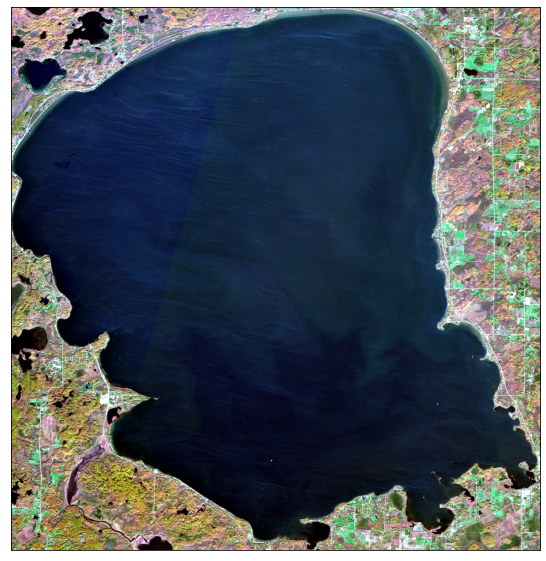

In [28]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)
plt.show()

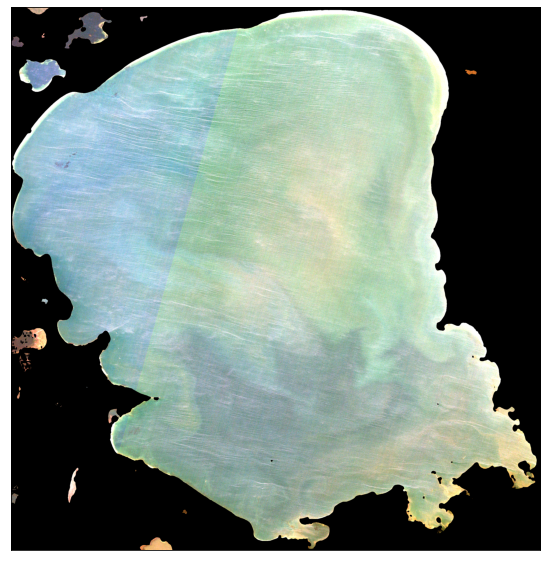

In [29]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, f'{acolite_product}_data'),
    stretch=True
)
plt.show()

In [30]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)


def get_stumpf_log_ratio(eopatch, feature, data_mask, n=10000, eps_bias=0.0000000000001):
    # apply very small bias to not divide by zero
    blue_band = eopatch[feature][0,:,:,1][data_mask == 1] + eps_bias
    green_band = eopatch[feature][0,:,:,2][data_mask == 1] + eps_bias

    # in stumpf log-ratio this would correspond to z (or rel_z) before applying the constant factor c and the intercept m_0
    # we can get to these values by fitting a linear regression
    X = np.log(n * blue_band) / np.log(n * green_band)
    X = X.reshape(-1, 1)

    return X


X = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)

y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 1), (4159120,))

In [31]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [32]:
score = reg.score(X, y)
score

0.14039138904145543

In [33]:
from sklearn.metrics import mean_absolute_error

ypred = reg.predict(X)
mean_absolute_error(y, ypred)

6.758171539817963

In [34]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)

X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)

y_hat_all = reg.predict(X_all)
estimated_bathymetry_stumpf_logratio = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
estimated_bathymetry_stumpf_logratio[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

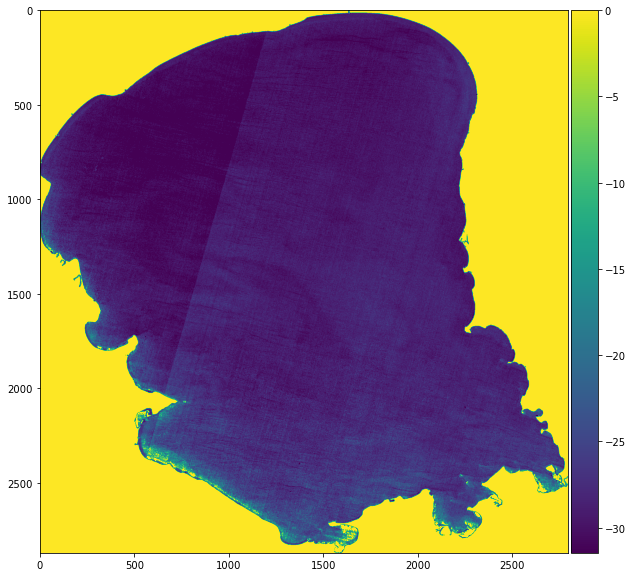

In [35]:
eolx.visualization.plot_ndarray_band(estimated_bathymetry_stumpf_logratio, cmap='viridis')
plt.show()

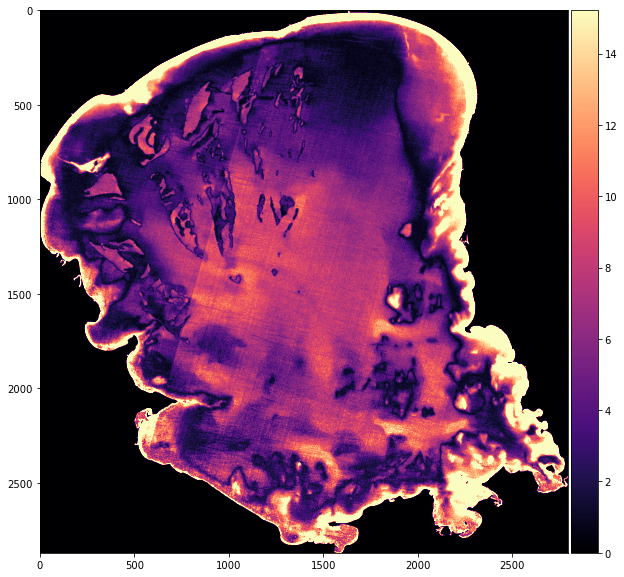

In [36]:
bathymetry_residuals_map = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')] - estimated_bathymetry_stumpf_logratio
eolx.visualization.plot_ndarray_band(np.abs(bathymetry_residuals_map), cmap='magma')
plt.show()

In [37]:
y_all = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1]
bathymetry_residuals = y_all - y_hat_all
bathymetry_residuals.shape

(5198175,)

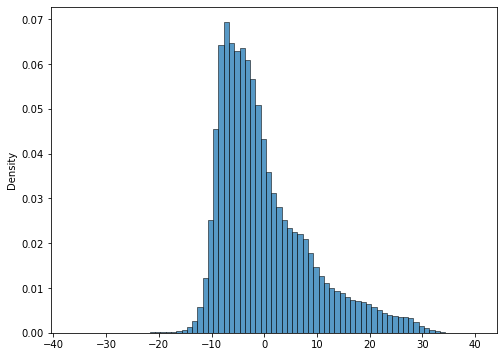

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(bathymetry_residuals, binwidth=1, stat='density', ax=ax)
plt.show()

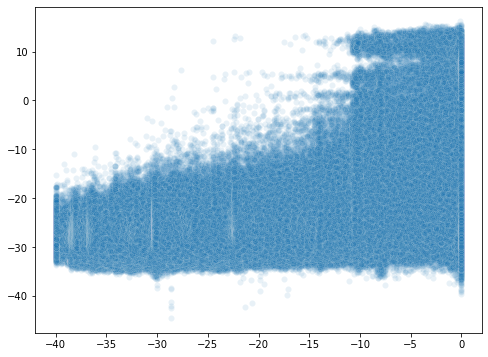

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=y_hat_all, alpha=0.1, ax=ax)
plt.show()

In [40]:
np.corrcoef(y_all, y_hat_all)

array([[1.        , 0.37421835],
       [0.37421835, 1.        ]])

## Stumpf Log-Ratio with Acolite

In [41]:
X = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), train_mask_single_band)

y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 1), (4159120,))

In [42]:
reg = LinearRegression()
reg.fit(X, y)

score = reg.score(X, y)
score

0.0006655829565889171

In [43]:
from sklearn.metrics import mean_absolute_error

ypred = reg.predict(X)
mean_absolute_error(y, ypred)

7.373276

In [44]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)

X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), mask_complete_single_band)

y_hat_all = reg.predict(X_all)
estimated_bathymetry_stumpf_logratio = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
estimated_bathymetry_stumpf_logratio[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

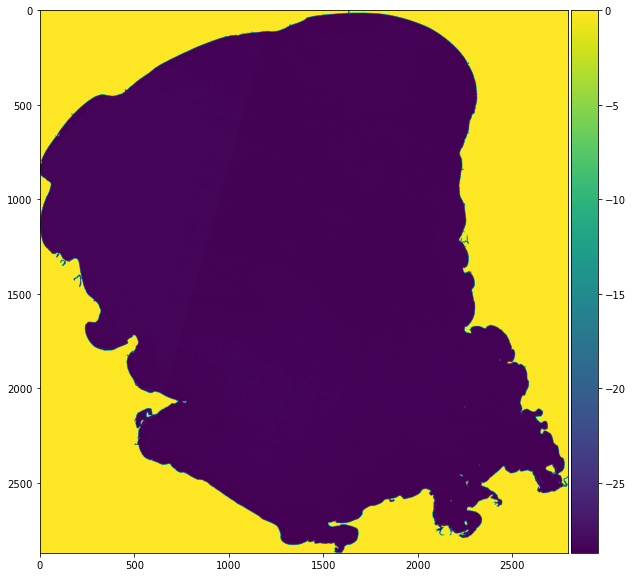

In [45]:
eolx.visualization.plot_ndarray_band(estimated_bathymetry_stumpf_logratio, cmap='viridis')
plt.show()

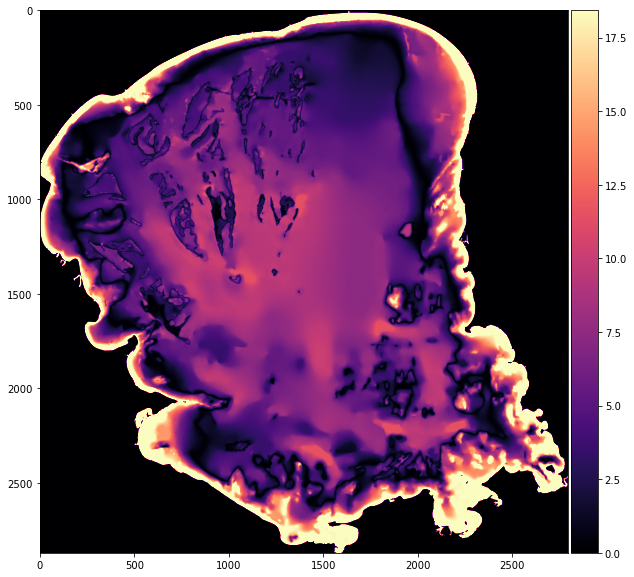

In [46]:
bathymetry_residuals_map = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')] - estimated_bathymetry_stumpf_logratio
eolx.visualization.plot_ndarray_band(np.abs(bathymetry_residuals_map), cmap='magma')
plt.show()